<a href="https://colab.research.google.com/github/IT21161056/Papaya-Buddy/blob/anoj/visiontransformer_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Data Science Libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import random

# Import Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Image Transformation and Augmentation Libraries
from torchvision import transforms
import torchvision.transforms as transforms

# HuggingFace Transformers Libraries
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTConfig

# Learning Rate Scheduling and Callbacks in PyTorch
from torch.optim.lr_scheduler import ReduceLROnPlateau

# System Libraries
import os
from datetime import datetime
from collections import Counter

# Progress Bar Library
from tqdm import tqdm

import time
import csv


In [ ]:
# Define hyperparameters - adjusted for binary classification
NUM_EPOCHS = 10  # Reduced epochs since binary classification often converges faster
# LEARNING_RATE = 5e-5  # Reduced learning rate for more stable training
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.005  # Reduced weight decay since dataset is likely smaller
BATCH_SIZE = 32  # Smaller batch size for better generalization


In [ ]:
# Path to your main dataset
dataset_path = '/content/drive/MyDrive/data_set/disease_identification'

# Classes in your dataset
classes = ['cercospora', 'mosaic']

# Define the split ratio (80% train, 20% validation)
train_size = 0.8

# Create lists to store image paths and their labels
image_paths = []
labels = []

In [ ]:
# Iterate over each class folder and collect image paths
class_counts = {}
for label, class_name in enumerate(classes):
    class_folder = os.path.join(dataset_path, class_name)
    class_images = [img_name for img_name in os.listdir(class_folder)
                   if img_name.endswith(('.jpg', '.png'))]
    class_counts[class_name] = len(class_images)

    for img_name in class_images:
        image_paths.append(os.path.join(class_folder, img_name))
        labels.append(label)


In [ ]:
# Print total dataset statistics
print("\nTotal Dataset Distribution:")
total_images = sum(class_counts.values())
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images ({count/total_images*100:.1f}%)")
print(f"Total images: {total_images}")


Total Dataset Distribution:
cercospora: 429 images (64.1%)
mosaic: 240 images (35.9%)
Total images: 669


In [ ]:
plot_labels = class_counts.keys()
plot_sizes = class_counts.values()

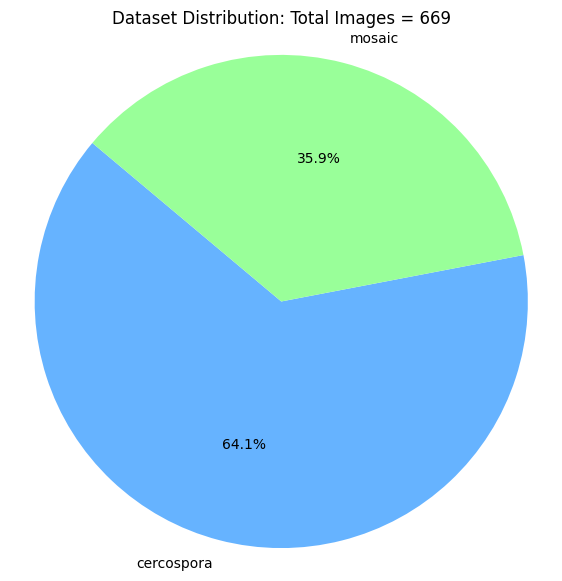

In [ ]:
# Plotting the pie chart
plt.figure(figsize=(7, 7))
plt.pie(plot_sizes, labels=plot_labels, autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#99ff99'])
plt.title(f"Dataset Distribution: Total Images = {total_images}")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
# Split the data into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, train_size=train_size, stratify=labels, random_state=42
)

In [ ]:
# Count distribution in splits
train_label_counts = Counter([classes[label] for label in train_labels])
val_label_counts = Counter([classes[label] for label in val_labels])

print("\nTraining Set Distribution:")
for class_name in classes:
    count = train_label_counts[class_name]
    print(f"{class_name}: {count} images ({count/len(train_labels)*100:.1f}%)")
print(f"Total training images: {len(train_labels)}")

print("\nValidation Set Distribution:")
for class_name in classes:
    count = val_label_counts[class_name]
    print(f"{class_name}: {count} images ({count/len(val_labels)*100:.1f}%)")
print(f"Total validation images: {len(val_labels)}")



Training Set Distribution:
cercospora: 343 images (64.1%)
mosaic: 192 images (35.9%)
Total training images: 535

Validation Set Distribution:
cercospora: 86 images (64.2%)
mosaic: 48 images (35.8%)
Total validation images: 134


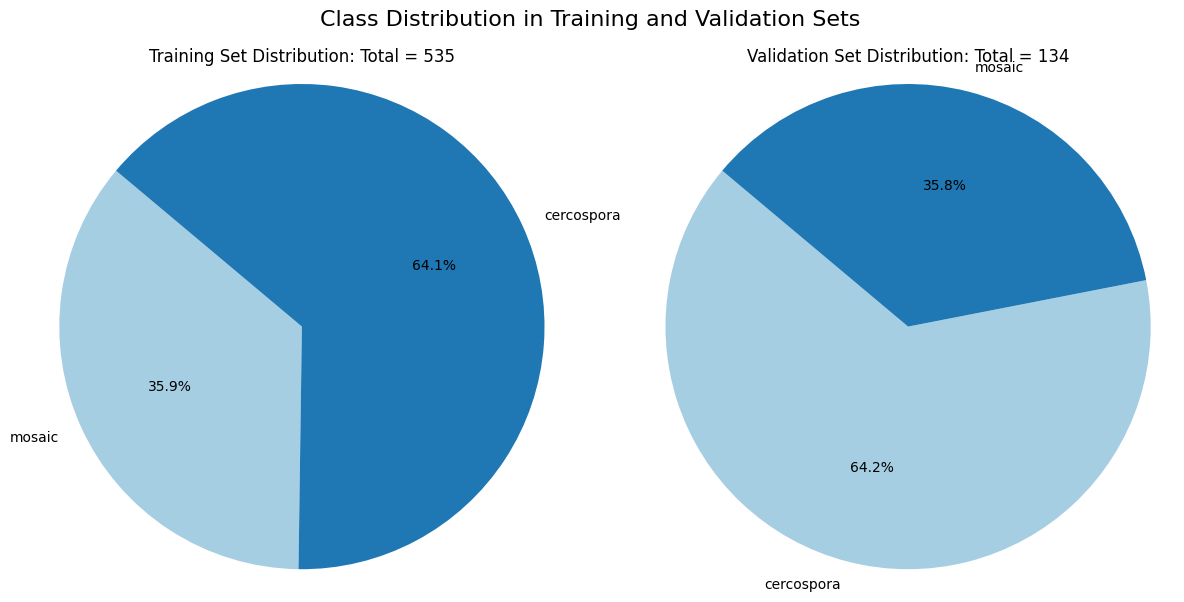

In [ ]:
# Training Set Distribution
train_labels = list(train_label_counts.keys())
train_counts = list(train_label_counts.values())

# Validation Set Distribution
val_labels = list(val_label_counts.keys())
val_counts = list(val_label_counts.values())

# Plotting the Pie Chart for Training Set Distribution
plt.figure(figsize=(12, 6))

# Subplot 1: Training Set
plt.subplot(1, 2, 1)
plt.pie(train_counts, labels=train_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors[:len(train_labels)])
plt.title(f"Training Set Distribution: Total = {sum(train_counts)}")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Subplot 2: Validation Set
plt.subplot(1, 2, 2)
plt.pie(val_counts, labels=val_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors[:len(val_labels)])
plt.title(f"Validation Set Distribution: Total = {sum(val_counts)}")
plt.axis('equal')

plt.suptitle('Class Distribution in Training and Validation Sets', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
class DiseaseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')  # Open image

        # Apply transformations (optional)
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Define data transformations (e.g., resize, normalize)
IMG_SIZE = 224
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.75, 1.33), interpolation=transforms.InterpolationMode.BICUBIC),  # Crop the best area
    transforms.RandomHorizontalFlip(p=0.5),  # Flip with 50% probability
    transforms.RandomRotation(degrees=5, expand=False),  # Restrict rotation to ±5°
    transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.02),  # Minor color adjustments
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

In [ ]:
# Define validation transformation (no random augmentations)
val_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # Resize image to 224x224
    transforms.CenterCrop(IMG_SIZE),  # Center crop if the image is larger
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with the same mean and std
])



In [ ]:
# Create Dataset objects for training and validation
train_dataset = DiseaseDataset(train_paths, train_labels, transform=train_transform)
val_dataset = DiseaseDataset(val_paths, val_labels, transform=val_transform)

In [ ]:
# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Example of how to access data
for images, labels in train_loader:
    print(images.shape, labels.shape)  # For example: torch.Size([32, 3, 224, 224]) torch.Size([32])
    break  # Just print one batch for demonstration


torch.Size([32, 3, 224, 224]) torch.Size([32])


# Load Pretrained Vision Transformer Model

In [ ]:
def initialize_model(num_classes, device):
    # Load the model with binary classification setup
    config = ViTConfig.from_pretrained(
        'google/vit-base-patch16-224',
        num_labels=num_classes,
        image_size=224
    )

    model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224',
        config=config,
        ignore_mismatched_sizes=True
    )

    # Simpler classifier for binary classification
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),  # Increased dropout for better regularization
        nn.Linear(model.config.hidden_size, num_classes)
    )

    return model.to(device)

In [ ]:
# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Initialize model
model = initialize_model(num_classes=len(classes), device=device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Optimizer with more conservative settings
optimizer = optim.AdamW(
    [
        {'params': [p for n, p in model.named_parameters() if 'classifier' not in n], 'lr': LEARNING_RATE * 0.1},
        {'params': model.classifier.parameters(), 'lr': LEARNING_RATE}
    ],
    weight_decay=WEIGHT_DECAY
)

In [ ]:
# Use ReduceLROnPlateau instead of CosineAnnealing for more adaptive learning rate adjustment
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

In [ ]:
# Loss function with class weight balancing if needed
criterion = nn.CrossEntropyLoss()

In [ ]:
def save_entire_model(model, save_directory):
    """
    Save the entire model for later use, including its structure and parameters.
    """
    # Ensure the save directory exists
    os.makedirs(save_directory, exist_ok=True)

    # Generate a unique filename with timestamp
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    model_save_path = os.path.join(save_directory, f"vit_entire_model_{timestamp}.pth")

    # Save the entire model
    torch.save(model, model_save_path)
    print(f"Entire model saved at {model_save_path}")

# Training Loop

In [ ]:
def train_disease_model(model, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs=5, save_path=None):
    model.train()

    # Create directory for saving training logs if specified
    if save_path:
        os.makedirs(save_path, exist_ok=True)

        # Generate a unique timestamp-based filename
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        csv_file = os.path.join(save_path, f"vit_training_log_{timestamp}.csv")
        fieldnames = ["epoch", "train_loss", "train_accuracy", "val_loss", "val_accuracy"]

        # Initialize CSV with header
        with open(csv_file, mode="w", newline="", encoding="utf-8") as file:
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writeheader()

    for epoch in range(num_epochs):
        # Train phase
        model.train()
        running_train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

            # Calculate accuracy for this batch
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy for the epoch
        train_epoch_loss = running_train_loss / len(train_dataloader.dataset)
        train_accuracy = 100 * train_correct / train_total
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():  # Disable gradient computation for validation
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs).logits
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)

                # Calculate accuracy for this batch
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy for the epoch
        val_epoch_loss = running_val_loss / len(val_dataloader.dataset)
        val_accuracy = 100 * val_correct / val_total
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Save the epoch's data to the CSV file
        if save_path:
            with open(csv_file, mode="a", newline="", encoding="utf-8") as file:
                writer = csv.DictWriter(file, fieldnames=fieldnames)
                writer.writerow({"epoch": epoch + 1,
                                 "train_loss": train_epoch_loss,
                                 "train_accuracy": train_accuracy,
                                 "val_loss": val_epoch_loss,
                                 "val_accuracy": val_accuracy})

    print("Finished Training ViT for Disease Classification")
    return model


In [ ]:
# Train the model
trained_model = train_disease_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,  # or 'cpu',
    NUM_EPOCHS,
    '/content/drive/MyDrive/training_outputs'
)

Epoch [1/5], Train Loss: 0.5542, Train Accuracy: 70.09%
Epoch [1/5], Val Loss: 0.3876, Val Accuracy: 82.84%
Epoch [2/5], Train Loss: 0.2406, Train Accuracy: 93.46%
Epoch [2/5], Val Loss: 0.2099, Val Accuracy: 94.03%
Epoch [3/5], Train Loss: 0.1440, Train Accuracy: 97.76%
Epoch [3/5], Val Loss: 0.1446, Val Accuracy: 95.52%
Epoch [4/5], Train Loss: 0.0842, Train Accuracy: 98.88%
Epoch [4/5], Val Loss: 0.1064, Val Accuracy: 96.27%
Epoch [5/5], Train Loss: 0.0591, Train Accuracy: 99.25%
Epoch [5/5], Val Loss: 0.0720, Val Accuracy: 97.76%
Finished Training ViT for Disease Classification


In [ ]:
# Define the directory where the model should be saved
models_path = '/content/drive/MyDrive/models'

In [ ]:
# Save the entire model after training
save_entire_model(trained_model, models_path)

Entire model saved at /content/drive/MyDrive/models/vit_entire_model_20241130-054801.pth


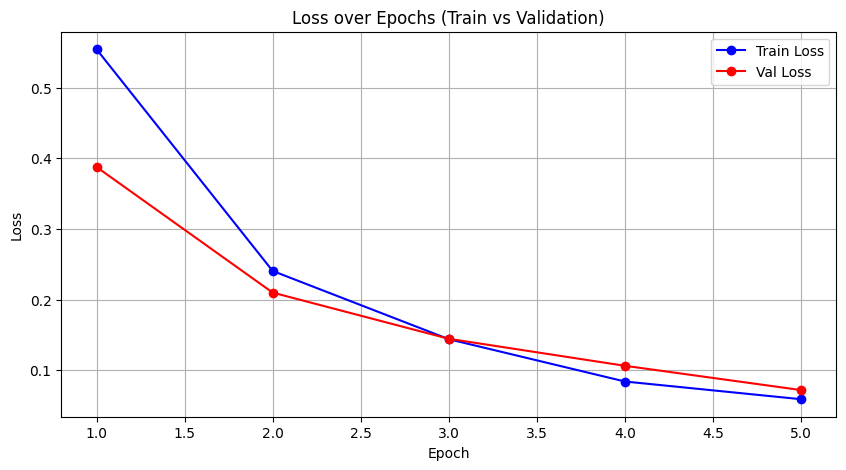

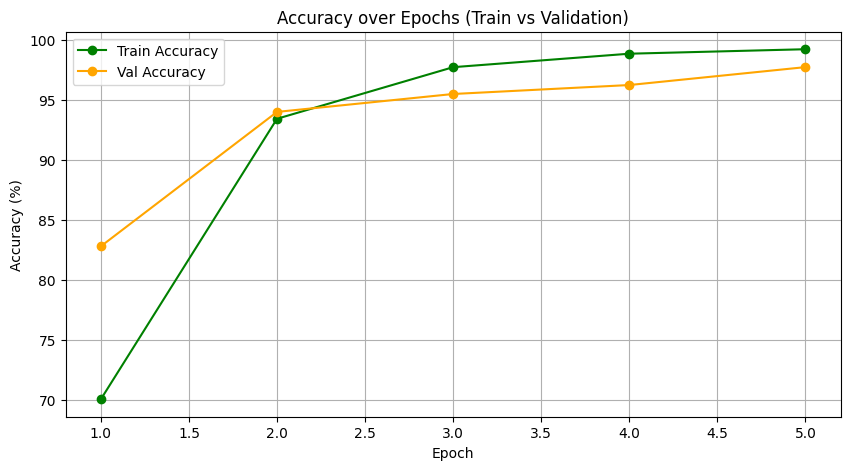

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the new CSV file containing the training and validation logs
new_file_path = '/content/drive/MyDrive/training_outputs/vit_training_log_20241130-050241.csv'
new_data = pd.read_csv(new_file_path)

# Plotting Loss over Epochs (Train vs Validation)
plt.figure(figsize=(10, 5))
plt.plot(new_data['epoch'], new_data['train_loss'], marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(new_data['epoch'], new_data['val_loss'], marker='o', linestyle='-', color='r', label='Val Loss')
plt.title('Loss over Epochs (Train vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Accuracy over Epochs (Train vs Validation)
plt.figure(figsize=(10, 5))
plt.plot(new_data['epoch'], new_data['train_accuracy'], marker='o', linestyle='-', color='g', label='Train Accuracy')
plt.plot(new_data['epoch'], new_data['val_accuracy'], marker='o', linestyle='-', color='orange', label='Val Accuracy')
plt.title('Accuracy over Epochs (Train vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()



#Load the saved model

In [ ]:
# Loading the entire model
def load_entire_model(model_path):
    model = torch.load(model_path)
    model.eval()
    print(f"Entire model loaded from {model_path}")
    return model

In [ ]:
# Load the entire model
model_path = '/content/drive/MyDrive/models/vit_entire_model_20241130-054801.pth'
my_vit_model = load_entire_model(model_path)

<ipython-input-97-e7238867e821>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


Entire model loaded from /content/drive/MyDrive/models/vit_entire_model_20241130-054801.pth


#Predict

In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F

# Assuming 'predict_disease' is your prediction function,
# and 'my_vit_model' is your trained ViT model.
# The 'train_transform' is the transform applied to input images (as you showed earlier).
# Also, 'device' is your device (CPU or CUDA).

# Define the class labels (modify this as per your actual classes)
classes = {0: 'cercospora', 1: 'mosaic'}  # Update this with your actual class names

def predict_disease(model, image_path, device, transform):
    # Open and transform the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Get the model's prediction
    with torch.no_grad():
        outputs = model(image).logits  # Assuming your model outputs logits
        probabilities = F.softmax(outputs, dim=1)  # Get probabilities
        predicted_class = torch.argmax(probabilities, dim=1).item()  # Get the predicted class

    return predicted_class, probabilities



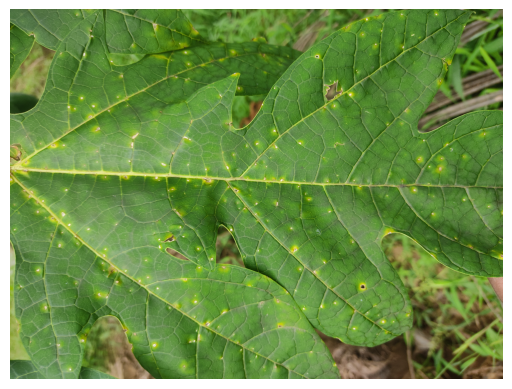

Predicted Disease Class: cercospora
Confidence: 98.52%
cercospora: 98.52%
mosaic: 1.48%


In [ ]:
# Input image path
image_path = '/content/drive/MyDrive/test_data/cercospora_image_1.jpg'

# Display the image
image1 = Image.open(image_path).convert('RGB')
plt.imshow(image1)
plt.axis('off')  # Hide axes
plt.show()

# Predict the disease
predicted_class, probabilities = predict_disease(my_vit_model, image_path, device, train_transform)

# Output the prediction details
predicted_label = classes[predicted_class]
confidence = probabilities[0][predicted_class].item() * 100  # Convert to percentage

print(f"Predicted Disease Class: {predicted_label}")
print(f"Confidence: {confidence:.2f}%")

# Show all class probabilities (optional)
for i, (class_idx, class_name) in enumerate(classes.items()):
    prob = probabilities[0][i].item() * 100  # Convert to percentage
    print(f"{class_name}: {prob:.2f}%")